In [96]:
import h2oai_client
import numpy as np
import pandas as pd

import requests
import math
from sklearn import model_selection
from h2oai_client import Client, ModelParameters, InterpretParameters

In [97]:
# Let's connect to the Driverless AI instance

address = 'http://localhost:12345'
username = 'h2oai'
password = 'i-00078c7033bc8a984'
h2oai = Client(address = address, username = username, password = password)

# make sure to use the same user name and password when signing in through the GUI

In [98]:
# Download 2007-2011 loan data from Lending Club Website

!wget "https://resources.lendingclub.com/LoanStats3a.csv.zip"

# More data available downloadable from this Lending Club URL (through a browser):
# https://www.lendingclub.com/info/download-data.action

# If you want to look at the data dictionary for the cols, here where you can find it
# https://resources.lendingclub.com/LCDataDictionary.xlsx

--2019-03-07 23:16:42--  https://resources.lendingclub.com/LoanStats3a.csv.zip
Resolving resources.lendingclub.com (resources.lendingclub.com)... 64.48.1.20
Connecting to resources.lendingclub.com (resources.lendingclub.com)|64.48.1.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘LoanStats3a.csv.zip.1’

    [                     <=>               ] 9,610,863    945KB/s   in 10s    

2019-03-07 23:16:53 (926 KB/s) - ‘LoanStats3a.csv.zip.1’ saved [9610863]



In [99]:
# Very first row has non-header data and hence skipping it. Read to a data frame

lc = pd.read_csv("LoanStats3a.csv.zip", low_memory=False, skiprows=1) 


In [100]:
# Normalize target column values for a simple binary classification problem

lc['loan_status'] = np.where(lc['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid', 'Fully Paid', lc['loan_status'])
lc['loan_status'] = np.where(lc['loan_status'] == 'Does not meet the credit policy. Status:Charged Off', 'Charged Off', lc['loan_status'])

# Let's look at the unique values for the target col. Yes - it's a binary classification problem
lc.loan_status.unique()

array(['Fully Paid', 'Charged Off', nan], dtype=object)

In [101]:
# Do the training/test split with 80%, 20%
train_lc, test_lc = model_selection.train_test_split(lc, test_size=0.2, random_state=2018)
train_lc.to_csv("/data/train_lc.csv", index=False)
test_lc.to_csv("/data/test_lc.csv", index=False)

# View the top few rows with header
train_lc.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
18986,NaN,NaN,19000.0,19000.0,19000.000000,36 months,10.37%,616.39,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
38563,NaN,NaN,7000.0,6400.0,1046.224432,36 months,13.17%,216.17,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
11396,NaN,NaN,15000.0,15000.0,15000.000000,36 months,5.99%,456.27,A,A2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
31346,NaN,NaN,3250.0,3250.0,3225.000000,36 months,10.99%,106.39,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
41268,NaN,NaN,6000.0,6000.0,5975.000000,36 months,15.68%,210.01,E,E1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
# Upload the data to Driverless AI

train_path = "/data/train_lc.csv"
test_path = "/data/test_lc.csv"

train = h2oai.create_dataset_sync(train_path)
test = h2oai.create_dataset_sync(test_path)

In [103]:
# Check the shape of the data

print('Train Dataset: ', len(train.columns), 'x', train.row_count)
print('Test Dataset: ', len(test.columns), 'x', test.row_count)

Train Dataset:  145 x 34030
Test Dataset:  145 x 8508


In [104]:
# List of training columns (should be same for test data also)
[c.name for c in train.columns]

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_

In [105]:
# Let's look at the Experiment Preview

target='loan_status'
exp_preview = h2oai.get_experiment_preview_sync(dataset_key= train.key, 
                                                validset_key='', 
                                                classification=True, 
                                                # All dropped cols are target leakage cols
                                                dropped_cols = ['inq_last_6mths', 
                                                                'out_prncp', 
                                                                'out_prncp_inv', 
                                                                'total_pymnt', 
                                                                'total_pymnt_inv', 
                                                                'total_rec_prncp', 
                                                                'total_rec_int', 
                                                                'total_rec_late_fee', 
                                                                'recoveries', 
                                                                'collection_recovery_fee', 
                                                                'last_pymnt_d', 
                                                                'last_pymnt_amnt', 
                                                                'next_pymnt_d', 
                                                                'last_credit_pull_d'] , 
                                                target_col=target, 
                                                is_time_series = False, 
                                                enable_gpus = True, 
                                                accuracy = 5, time = 2, interpretability = 5, 
                                                config_overrides = None)
exp_preview

['ACCURACY [5/10]:',
 '- Training data size: *34,030 rows, 41 cols*',
 '- Feature evolution: *[LightGBM, XGBoost]*, *1/3 validation split*',
 '- Final pipeline: *Ensemble (4 models), 4-fold CV*',
 '',
 'TIME [2/10]:',
 '- Feature evolution: *4 individuals*, up to *26 iterations*',
 '- Early stopping: After *5* iterations of no improvement',
 '',
 'INTERPRETABILITY [5/10]:',
 '- Feature pre-pruning strategy: None',
 '- XGBoost Monotonicity constraints: disabled',
 '- Feature engineering search space (where applicable): [Clustering, Date, FrequencyEncoding, Identity, Interactions, IsHoliday, NumEncoding, OneHotEncoding, TargetEncoding, Text, TextBiGRU, TextCNN, TextCharCNN, TextLin, TruncatedSVD, WeightOfEvidence]',
 '',
 '[LightGBM, XGBoost] models to train:',
 '- Model and feature tuning: *16*',
 '- Feature evolution: *24*',
 '- Final pipeline: *4*',
 '',
 'Estimated runtime: *minutes*']

In [107]:
# Run the Experiment with 5,2,5 settings. So it will be an ensemble quickly and also some basic feature engineering
# Its a Classification problem with column 'loan_status' as target_col
# It took roughly 22 min on a single GPU instance on AWS with these settings
# If you want to do a quick experiment, try 1,2,5 

experiment = h2oai.start_experiment_sync(dataset_key=train.key,
                                         testset_key = test.key,
                                         target_col=target,
                                         is_classification=True,
                                         accuracy=5,
                                         time=2,
                                         interpretability=5,
                                         scorer="AUC",
                                         enable_gpus=True,
                                         seed=1234,
                                         # drop the target leakage cols
                                         cols_to_drop=['inq_last_6mths', 
                                                        'out_prncp', 
                                                        'out_prncp_inv', 
                                                        'total_pymnt', 
                                                        'total_pymnt_inv', 
                                                        'total_rec_prncp', 
                                                        'total_rec_int', 
                                                        'total_rec_late_fee', 
                                                        'recoveries', 
                                                        'collection_recovery_fee', 
                                                        'last_pymnt_d', 
                                                        'last_pymnt_amnt', 
                                                        'next_pymnt_d', 
                                                        'last_credit_pull_d'
                                                        ]
                                        )

In [108]:
print("Final Model Score on Validation Data: " + str(round(experiment.valid_score, 3)))
print("Final Model Score on Test Data: " + str(round(experiment.test_score, 3)))

Final Model Score on Validation Data: 0.711
Final Model Score on Test Data: 0.707


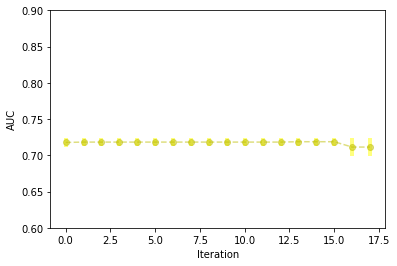

In [111]:
# Let's visualize the feature evolution and model tuning

import matplotlib.pyplot as plt
%matplotlib inline

# Add scores from experiment iterations
iteration_data = h2oai.list_model_iteration_data(experiment.key, 0, len(experiment.iteration_data))
iterations = list(map(lambda iteration: iteration.iteration, iteration_data))
scores_mean = list(map(lambda iteration: iteration.score_mean, iteration_data))
scores_sd = list(map(lambda iteration: iteration.score_sd, iteration_data))

# Add score from final ensemble
iterations = iterations + [max(iterations) + 1]
scores_mean = scores_mean + [experiment.valid_score]
scores_sd = scores_sd + [experiment.valid_score_sd]

plt.figure()
plt.errorbar(iterations, scores_mean, yerr=scores_sd, color = "y", 
             ecolor='yellow', fmt = '--o', elinewidth = 4, alpha = 0.5)
plt.xlabel("Iteration")
plt.ylabel("AUC")
plt.ylim([0.6, .9])
plt.show();

In [112]:
h2oai.download(src_path=experiment.test_predictions_path, dest_dir=".")

'./test_preds.csv'

In [113]:
test_preds = pd.read_csv("./test_preds.csv")
test_preds.head()

,loan_status.Charged Off,loan_status.Fully Paid
0,0.045696,0.954304
1,0.135316,0.864684
2,0.074095,0.925905
3,0.090651,0.909349
4,0.239576,0.760424


We can also download and examine the summary of the experiment and feature importance for the final model.

In [114]:
# Download Summary
import subprocess
summary_path = h2oai.download(src_path=experiment.summary_path, dest_dir=".")
dir_path = "./h2oai_experiment_summary_" + experiment.key
subprocess.call(['unzip', '-o', summary_path, '-d', dir_path], shell=False)

0

The table below shows the feature name, its relative importance, and a description.  Some features will be engineered by Driverless AI and some can be the original feature.

In [115]:
# View Features
features = pd.read_table(dir_path + "/ensemble_features.txt", sep=',', skipinitialspace=True)
features.head(n = 10)

,Relative Importance,Feature,Description
0,1.00000,33_funded_amnt_inv,funded_amnt_inv (original)
1,0.79326,26_annual_inc,annual_inc (original)
2,0.64354,22_OHE:sub_grade.0,One-hot encoding for column(s) ['sub_grade'] b...
3,0.63745,18_OHE:grade.0,One-hot encoding for column(s) ['grade'] binne...
4,0.61834,5_Freq:grade,Encoding of categorical levels of feature(s) [...
5,0.56139,12_Freq:term,Encoding of categorical levels of feature(s) [...
6,0.36367,51_Txt:desc.8,Feature #9 of tf-idf-based word embedding (fo...
7,0.35362,1_Freq:debt_settlement_flag,Encoding of categorical levels of feature(s) [...
8,0.32677,20_OHE:purpose.7,One-hot encoding for column(s) ['purpose'] bin...
9,0.28690,35_loan_amnt,loan_amnt (original)


In [ ]:
# Hope it was fun - Karthik Guruswamy, Principal Solutions Architect/Customer Data Scientist, H2O.ai